In [1]:
from __future__ import print_function, division
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, transform

In [2]:
plt.rcParams['figure.figsize'] = [15,15]

## Understanding Images and Labels

In [3]:
train_labels = pd.read_json("det_train_shortened.json") # pandas df

In [5]:
def draw_bounding_box(im, train_labels):
    """
    Solely for retrieving raw bounding box data and drawing on raw image.
    
    Not used later on.

    Input:
    =im=            testing image
    =train_labels=  raw json file with all labels

    Output:
    =plt.plot=      bounding boxes drawn ontop of testing image
    """
    plt.imshow(im)

    # save coordinates to appropriate label
    for object in train_labels["labels"][0]:
        x_min = object["box2d"]["x1"]
        x_max = object["box2d"]["x2"]
        y_min = object["box2d"]["y1"]
        y_max = object["box2d"]["y2"]
        # form list in order so that we can draw bbox in full
        x_points = [x_min, x_min, x_max, x_max, x_min]
        y_points = [y_min, y_max, y_max, y_min, y_min]

        plt.plot(x_points, y_points, 'r-')

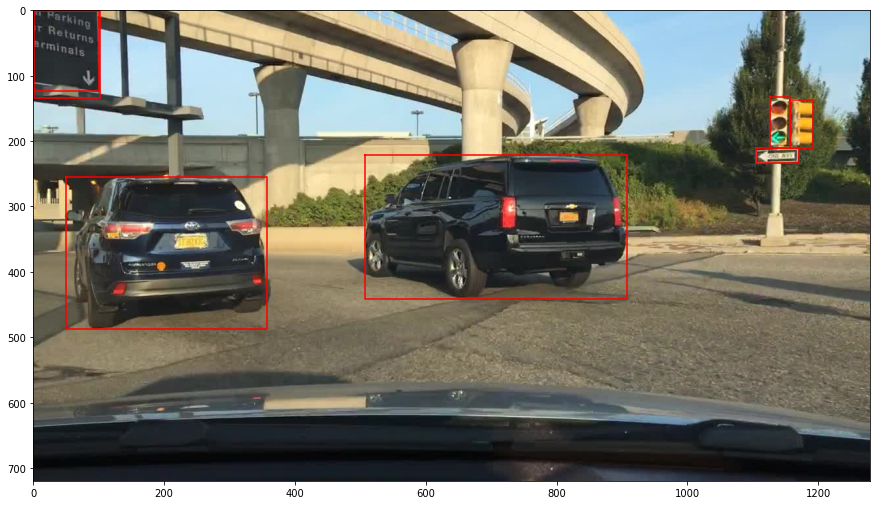

In [7]:
im = plt.imread("0000f77c-6257be58.jpg")
draw_bounding_box(im, train_labels)

## Parsing Useful Labels

In [ ]:
# current structure



# pd dataframe doesnt seem viable - varying number of objects in each image

In [8]:
def filter_labels(raw_json):
    """
    Re-organises json file into dictionary, such that:
        - keys =    image names.
        - values =  list of dictionaries which contain key value information for each labelled 
                    object in frame.
    
    For later down the track (segmentation, lane detection), other labels will be let thru.
    -----------------------------------------------------------------------------------------
    The structure is as follows:

    data_labels = {
                    'im_name1.jpg' : [ 
                        {obj1_category: car, obj1_bboxes: [{x1:x1},{y1:y1},{x2:x2},{y2:y2}]},
                        {obj2_category: car, obj2_bboxes: [{x1:x1},{y1:y1},{x2:x2},{y2:y2}]},
                        ...
                    ],
                    'im_name2.jpg' : [ 
                        {obj1_category: car, obj1_bboxes: [{x1:x1},{y1:y1},{x2:x2},{y2:y2}]},
                        {obj2_category: car, obj2_bboxes: [{x1:x1},{y1:y1},{x2:x2},{y2:y2}]},
                        ...
                    ],
                }
    -----------------------------------------------------------------------------------------
    Input:
    =raw_json=      raw json file containing all labels corresponding to image dataset.

    Output:
    =data_labels=   dictionary with appropriate labels corresponding to image name.
    """
    data_labels = {}
    for idx, label in enumerate(raw_json["labels"]):
        objects = []
        obj = {}

        for object in label:
            #obj["id"] = object["id"] # object id probs not useful?
            obj["category"] = object["category"]
            obj["box2d"] = object["box2d"]
            objects.append(obj)
            obj = {}

        data_labels[str(train_labels["name"][idx])] = objects
    
    return data_labels

In [9]:
labels_json = pd.read_json("det_train_shortened.json")
filtered_labels = filter_labels(labels_json)

## Load Images and Labels

In [ ]:
# for getitem
# {
#     img: image
#     category: [car, sign, ped]
#     box2d: [[x1, x2, y1, y2],
#             [x1, x2, y1, y2],
#             [x1, x2, y1, y2]]
# }

In [ ]:
# bbox_labels = [ [[c1], [c2], [c3]],
#                 [[c1], [c2], [c3]],
#                 ...
#             ]

In [58]:
class DetectionDataset(Dataset):
    """
    Object detection dataset with bounding box and category data.
    
    """
    def __init__(self, label_dict, root_dir, transform=None):
        """
        Args:
        =label_dict=    dictionary with key (image name) and value (object categories and bboxes).
        =root_dir=      directory with all images.
        =transform=     optional transform to be applied on a sample.
        """
        self.labels = label_dict
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return(len(self.labels))
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        ## collect all image names
        img_name = list(self.labels.keys())[idx]
        image = io.imread(os.path.join(self.root_dir, img_name))
        
        ## collect all labels per image
        category_labels = []
        for image_idx in range(len(filtered_labels)):
            curr_im_cat_labels = [obj["category"] for obj in list(filtered_labels.values())[image_idx]]
            category_labels.append(curr_im_cat_labels)
        categories = category_labels[idx]
        
        ## collect all bounding box coords per image
        # first create list of list of dictionaries exclusively full of bbox coordinates
        box2d_labels = []
        for image_idx in range(len(filtered_labels)):
            curr_im_box_labels = [obj["box2d"] for obj in list(filtered_labels.values())[image_idx]]
            box2d_labels.append(curr_im_box_labels)

        # now convert the list of list of dictionaries into list of list of list
        bbox_labels = []
        for image_labels in box2d_labels: # iterate through each image label set
            cur_image = []
            for bbox in image_labels: # iterate through each set of coords in image label set
                coords = []
                for _, bbox_value in bbox.items(): # iterate through each indiv coord and pull out values
                    # fill list with coords [x1, y1, x2, y2]
                    coords.append(bbox_value)
                # add the [x1, y1, x2, y2] to current image list
                cur_image.append(coords)

            # add the current image list to full list of images
            bbox_labels.append(cur_image)
        bboxes = bbox_labels[idx]
        bboxes = np.array(bboxes)

        sample = {"image": image, "categories": categories, "bboxes": bboxes}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [119]:
def draw_bbox(image, categories, bboxes):
    """
    Draw all bounding boxes over image.
    
    Inputs:
    =image=     image to be shown with bounding boxes.
    =bboxes=    bounding box coordinates as list.
    
    Outputs:
    =plt.plot=  image from dataset with bounding boxes drawn over it.
    """
    # display current image
    print(image.shape)
    plt.imshow(image)

    for obj in bboxes:
        # label coords appropriately
        x_min, y_min, x_max, y_max = obj
        # arrange coords in order such that we can draw the box in full
        x_points = [x_min, x_min, x_max, x_max, x_min]
        y_points = [y_min, y_max, y_max, y_min, y_min]

        plt.plot(x_points, y_points, 'r-')

## Test Loading in a Custom Dataset

# image_shape    n_objects
0 (720, 1280, 3) 7
1 (720, 1280, 3) 6


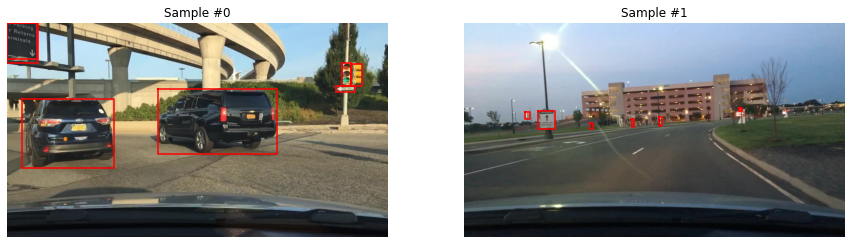

In [76]:
testing = DetectionDataset(
    label_dict=filtered_labels,
    root_dir="./images/",
)
fig = plt.figure()

print("# image_shape    n_objects")
for i in range(len(testing)):
    sample = testing[i]

    print(i, sample["image"].shape, len(sample["categories"]))

    ax = plt.subplot(1, 2, i+1)
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    draw_bbox(**sample)

## Transforms
1. normalise image (pixel values only)
2. rescale both image and bounding box coords
3. convert arrays to tensor (exclude categories)

In [120]:
class Normalise(object):
    """
    Normalise pixel values of image to range between [0, 1].
    """
    def __call__(self, sample):
        image, categories, bboxes = sample["image"], sample["categories"], sample["bboxes"]
        
        img = image/255

        return {"image": img, "categories": categories, "bboxes": bboxes} 

class Rescale(object):
    """
    Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple)) # make sure output size is EITHER int or tuple
        self.output_size = output_size

    def __call__(self, sample):
        image, categories, bboxes = sample["image"], sample["categories"], sample["bboxes"]

        h, w = image.shape[:2] # image.shape = (x, y, channels)
        if isinstance(self.output_size, int): # the int specifies the smaller dimension, other dim scales based on it
            if h > w:
                new_h, new_w = self.output_size*h/w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size*w/h
        else: # if tuple then completely specified dims
            new_h, new_w = self.output_size
        
        new_h, new_w = int(new_h), int(new_w)

        image = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        # broadcast (7, 4) * (1, 4)
        bboxes = bboxes * [new_w/w, new_h/h, new_w/w, new_h/h]

        return {"image": image, "categories": categories, "bboxes": bboxes}

class ToTensor(object):
    """
    Convert ndarrays in sample to Tensors.
    """

    def __call__(self, sample):
        image, categories, bboxes = sample["image"], sample["categories"], sample["bboxes"]

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image)
        
        # bboxes are simply H x W and axes stay the same
        bboxes = torch.from_numpy(bboxes)
        
        return {"image": image, "categories": categories, "bboxes": bboxes}

In [123]:
norm = Normalise()
scale = Rescale(128)
composed = transforms.Compose([
    Normalise(),
    Rescale(256)
])

(720, 1280, 3)
(128, 227, 3)
(256, 455, 3)


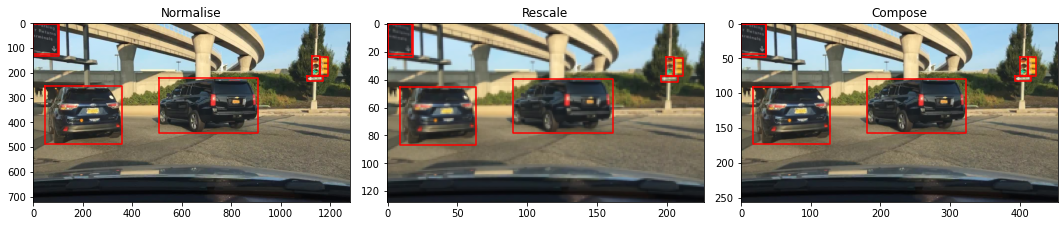

In [124]:
# Apply each transform on sample
fig = plt.figure()
sample = testing[0]
for i, tsfrm in enumerate([norm, scale, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i+1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    draw_bbox(**transformed_sample)

plt.show()